In [1]:
import numpy as np
from numpy import linalg
%matplotlib inline
import matplotlib.pyplot as plt
import mpl_toolkits
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.colors as colors
import rosbag
import glob
from urdf_parser_py.urdf import URDF
from pykdl_utils.kdl_parser import kdl_tree_from_urdf_model
from pykdl_utils.kdl_kinematics import KDLKinematics
import time
from IPython import display
import random

In [2]:
#this one also computes the end-effector prior
def kinematics_endeff(joint_angles):
    robot = URDF.from_xml_file('robot.urdf')
    kdl_kin_ee_dy = KDLKinematics(robot,'base_link','elbow2_link')
    
    ee_list_dy = []
    for joints in joint_angles:
        ee_list_dy.append(kdl_kin_ee_dy.forward(joints)) 
    return ee_list_dy

In [3]:
#this function computes the kinematics chain of the robot for plotting
def foward_kinematics_plot(joint_angles):
    robot = URDF.from_xml_file('robot.urdf')
    links = [rl.name for rl in robot.links]

    kdl_kin_turret_dy = KDLKinematics(robot,'base_link','turret_link')
    kdl_kin_shoulder_dy = KDLKinematics(robot,'base_link','shoulder_link')
    kdl_kin_elbo1_dy= KDLKinematics(robot,'base_link','elbow1_link')
    kdl_kin_ee_dy = KDLKinematics(robot,'base_link','elbow2_link')


    base_turretlist_dy = []
    base_shoulderlist_dy = []
    base_elbo1list_dy = []
    ee_list_dy = []
    for joints in joint_angles:
        pose_turret_fkmatrix = kdl_kin_turret_dy.forward(joints[:1])
        pose_shoulder_fkmatrix = kdl_kin_shoulder_dy.forward(joints[:2])
        pose_elbo1list_fkmatrix = kdl_kin_elbo1_dy.forward(joints[:2])
        pose_ee_fkmatrix = kdl_kin_ee_dy.forward(joints[:3])

        base_turretlist_dy.append(pose_turret_fkmatrix[0:3,3])
        base_shoulderlist_dy.append(pose_shoulder_fkmatrix[0:3,3])
        base_elbo1list_dy.append(pose_elbo1list_fkmatrix[0:3,3])
        ee_list_dy.append(pose_ee_fkmatrix[0:3,3])
    
    BaseTo_turret_xyz_dyna = (np.squeeze(np.array(base_turretlist_dy)))    
    BaseTo_shoulder_xyz_dyna = (np.squeeze(np.array(base_shoulderlist_dy)))    
    BaseTo_elbo1_xyz_dyna = (np.squeeze(np.array(base_elbo1list_dy)))    
    BaseTo_ee_xyz_dyna = (np.squeeze(np.array(ee_list_dy)))
    
    return BaseTo_turret_xyz_dyna,BaseTo_shoulder_xyz_dyna,BaseTo_elbo1_xyz_dyna,BaseTo_ee_xyz_dyna


In [4]:
#plotting the chains of the robot to make up the robot model
def robot3D(measurements,axis):
    ax.scatter3D((measurements[0][0]), (measurements[0][1]), (measurements[0][2]),
                     c='red',s=200, label ='joints',alpha=0.5)
    ax.scatter3D((measurements[1][0]), (measurements[1][1]), (measurements[1][2]),
                     c='red',s=200, label ='joints',alpha=0.5)
    ax.scatter3D((measurements[2][0]), (measurements[2][1]), (measurements[2][2]),
                     c='red',s=200, label ='joints',alpha=0.5)
    ax.scatter3D((measurements[3][0]), (measurements[3][1]), (measurements[3][2]),
                     c='red',s=200, label ='joints',alpha=0.5)

    ax.plot3D([measurements[0][0],measurements[1][0]], 
                  [measurements[0][1],measurements[1][1]], 
                  [measurements[0][2],measurements[1][2]], 
                  'green',linewidth=9.0, label='links')

    ax.plot3D([measurements[1][0],measurements[2][0]], 
                  [measurements[1][1],measurements[2][1]], 
                  [measurements[1][2],measurements[2][2]], 
                  'green',linewidth=9.0, label='links')

    ax.plot3D([measurements[2][0],measurements[3][0]], 
                  [measurements[2][1],measurements[3][1]], 
                  [measurements[2][2],measurements[3][2]], 
                  'green',linewidth=9.0, label='links')

    ax.set_xlabel('X axis', fontsize=16, fontweight='bold', color='red')
    ax.set_ylabel('Y axis',  fontsize=16, fontweight='bold', color='green')
    ax.set_zlabel('Z axis',  fontsize=16, fontweight='bold', color='blue')
    ax.set_title('3D Manipulator of two links',fontsize = 16, fontweight = 'bold')

In [5]:
#computing the sigma points
def sigma_points(mu,cov,n,lam):
#computes the cholesky decomposition of matrix square root A, 
#which assumes it to be a symmetric and positive definite matrix
    chol_A = np.linalg.cholesky((n+lam)*cov)
    sigma_pointx = np.zeros((7,len(mu)))
    sigma_pointx[0,:] = mu
    for i in range(3):
        sigma_pointx[i+1,:] =  mu + chol_A[:,i]
    for i in range(3):
        sigma_pointx[i+4,:] =  mu - chol_A[:,i]
    return sigma_pointx

In [6]:
#assigning weights to the computed sigmas
def weight_sigma(al,n,k,b,lam):
    c = n + lam
    w_mu = np.zeros((2 * n + 1,1))
    w_mu[0,0] = lam / c
    
    w_cov = np.zeros((2 * n + 1,1))
    w_cov[0,0] = w_mu[0,0] + (1 - al**2 + b)
    for i in range(6):
        w_mu[i+1,0] = 0.5/c
        w_cov[i+1,0] = 0.5/c
    return w_mu,w_cov

In [7]:
#estimating the resulting posterior distribution of the end-effector.
def estimate_distri(transformedpoints,weight_mean,weight_cov,n,resh):
    mu_Keeprime = np.zeros((resh,1))
    cov_Keeprime = np.zeros((resh,resh))
    for i in range(2*(n) + 1):
        mu_Keeprime = mu_Keeprime + weight_mean[i]*transformedpoints[i,:].reshape(resh,1)
    for i in range(2*(n) + 1):
        cov_Keeprime = cov_Keeprime + weight_cov[i]*(transformedpoints[i,:].reshape(resh,1) 
                    - mu_Keeprime).dot((transformedpoints[i,:].reshape(resh,1) - mu_Keeprime).T)
    return mu_Keeprime, cov_Keeprime

In [8]:
#computing the transformation from the base to the turretCam_link for camera transformation relative to the ee
def turretTransform(angle):
    robot = URDF.from_xml_file('robot.urdf')
    
    kdl_kin_turretUP_dy = KDLKinematics(robot,'base_link','turret_camera_link')
    
    return kdl_kin_turretUP_dy.forward(angle)

In [9]:
#Camera model that projects a point from 3D to image plane
def rtmapping(X_world,camTransform):
    K = np.matrix([[136.848632, 0.0, 128.029255, 0],[0.0, 138.204089, 86.254287, 0],[ 0.0, 0.0, 1.0, 0.0]]) 
    P = K * camTransform 
    x_im = P.dot(np.concatenate((X_world, np.array([1])), axis=0))
    return x_im

In [10]:
#converts the point to 2d
def endEffecImage2d(ee_ImaHomo):
    for i in range(len(ee_ImaHomo )):
        x= ee_ImaHomo[:,0]/ee_ImaHomo[:,2]
        y= ee_ImaHomo[:,1]/ee_ImaHomo[:,2]
        xx,yy = x.reshape(len(ee_ImaHomo),1),y.reshape(len(ee_ImaHomo),1)
    return np.hstack((xx,yy))

In [11]:
#plotting the end-effector distribution
def plot_ellipsoid(mu,cov,ax):
    ellipNumber = 3
    #set colour map so each ellipsoid as a unique colour
    norm = colors.Normalize(vmin=0, vmax=ellipNumber)
    cmap = cm.jet
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    #compute each and plot each ellipsoid iteratively
    for indx in range(ellipNumber):
        # your ellispsoid and center in matrix form
        A = cov
        center = mu
        # find the rotation matrix and radii of the axes
        radii, rotation = np.linalg.eig(A)
        #print(radii.shape)
        radii = np.sqrt(radii)#reduce radii by factor 0.3 
        # calculate cartesian coordinates for the ellipsoid surface
        u = np.linspace(0.0, 2.0 * np.pi, 60)
        v = np.linspace(0.0, np.pi, 60)
        x = radii[0] * np.outer(np.cos(u), np.sin(v))
        y = radii[1] * np.outer(np.sin(u), np.sin(v))
        z = radii[2] * np.outer(np.ones_like(u), np.cos(v))

        for i in range(len(x)):
            for j in range(len(x)):
                [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], rotation) + center

        ax.plot_surface(x, y, z,  rstride=3, cstride=3,  color=m.to_rgba(indx), linewidth=0.1, alpha=1.0, shade=True)
        ax.set_xlabel('X ', fontsize=20, fontweight='bold', color='red')
        ax.set_ylabel('Y',  fontsize=20, fontweight='bold', color='green')
        ax.set_zlabel('Z',  fontsize=20, fontweight='bold', color='blue')
#         ax.set_title('3D Manipulator of two links',fontsize = 20, fontweight = 'bold')
        plt.rcParams["font.size"] = 20
        plt.rcParams["font.weight"] = "bold"
        plt.rcParams["axes.labelweight"] = "bold"

In [12]:
#plotting the ee distribution in 2D
def plot2Dellipse(mu,cov,point,xlimit,ylimit,edgecolor,color):
    a = np.squeeze(np.asarray(point))
    x0,y0 = a
    lambda_, v = np.linalg.eig(cov)
    lambda_ = np.sqrt(lambda_)
    from matplotlib.patches import Ellipse
    import matplotlib.pyplot as plt
    ax = plt.subplot(111, aspect='equal')
    for j in range(1, 4):
        ell = Ellipse(xy=(mu[0], mu[1]),width=lambda_[0]*j*2, height=lambda_[1]*j*2,
                          angle=np.rad2deg(np.arccos(v[0, 0])),linewidth=4,edgecolor=edgecolor)
        ell.set_facecolor('none')
        ax.add_artist(ell)
    plt.scatter(x0, y0,c=color)
    #plt.scatter(x1, y1,c='blue')
    plt.xlim(xlimit)
    plt.ylim(ylimit)
    plt.xlabel('x-axis', fontsize=10)
    plt.ylabel('y-axis', fontsize=10)
    

In [13]:
# robot = URDF.from_xml_file('robot.urdf')
# kdl_kin_ee_dy = KDLKinematics(robot,'base_link','elbow2_link')
# kdl_kin_ee_dy.get_joint_names()

In [ ]:
robot = URDF.from_xml_file('robot.urdf')    
# kdl_kin_turretUP_dy = KDLKinematics(robot,'base_link','turret_camera_link')
# kdl_kin_turretUP_dy.get_joint_names()

In [ ]:
robot.

In [96]:
data_path = './Robot_ViconNovember/'

#loading the saved lists of databags
i = 1 

RobotKin_dy = np.load(data_path+'ja_array_dyna%d.npy'%i)
turretKin_dy = np.load(data_path+'ja_turretCam_dyna%d.npy'%i)
marker_dyn = np.load(data_path+'robot_dynaPosArr%d.npy'%i)

camera_angles = np.stack((RobotKin_dy[:,0],turretKin_dy)).T

#Unscented Transform parameters                                    
n_dim = 3
alpha = 0.5
kappa = 0
lamda = (((alpha)**2) * (n_dim + kappa) - n_dim)
beta = 2.0
resh1 = 3
resh2 = 2

# Define angle uncertainty
cov_theta = np.eye(3)*0.01

mu_theta = RobotKin_dy[0]
camera_angle = camera_angles[0]
marker_pos = marker_dyn[0]

#Propagate 3D marker measurement through camera (no rotation and translation)
sensordata_z = rtmapping(marker_pos, np.eye(4))
sensordata_in2d = endEffecImage2d(sensordata_z)

#measuremnt noise in pixels
m_noiseQ = 150 *np.eye(2,dtype=float)

In [101]:
#Generate sigma joint angle points
sigma_angles = sigma_points(mu_theta,cov_theta,n_dim,lamda)

#Calculate sigma joint angle weights
wsm, wsc = weight_sigma(alpha,n_dim,kappa,beta,lamda) 

#propagating the sigma angles thru fk
fbase_eeMatrices = kinematics_endeff(sigma_angles)
fbase_poses = []
for fbase in fbase_eeMatrices:
    fbase_poses.append(fbase[0:3,3])
    fbase_posesArr = np.array(fbase_poses)
fbase_posesArrshaped = ((np.reshape(fbase_posesArr, (7, 3))))

#Estimating the new Gaussian distribution of the end-effector space
mu_xee, covmat_xee = estimate_distri(fbase_posesArrshaped,wsm, wsc,n_dim,3)
mu_xee = mu_xee.reshape(3,)

Rx = np.array(([1,0,0],
               [0, np.cos(0), -np.sin(0)],
               [0, np.sin(0), np.cos(0)]))

# Ry = np.array(([[np.cos(np.pi), 0, np.sin(np.pi)],
#               [0, 1, 0],
#               [-np.sin(np.pi), 0, np.cos(np.pi)]]))

# Rz = np.array(([[np.cos(np.pi), -np.sin(np.pi),0],
#               [np.sin(np.pi), np.cos(np.pi),0],
#                [0,0,1]]))
             
Tcam = np.vstack((np.hstack((Rx,np.zeros((3,1)))),np.zeros((1,4))))
Tcam[3,3] = 1


# Tcamz = np.vstack((np.hstack((Rz,np.zeros((3,1)))),np.zeros((1,4))))
# Tcamz[3,3] = 1
             
turretCameraTrans4m = turretTransform(camera_angle).dot(Tcam) #.dot(Tcamz)

KeyboardInterrupt: 

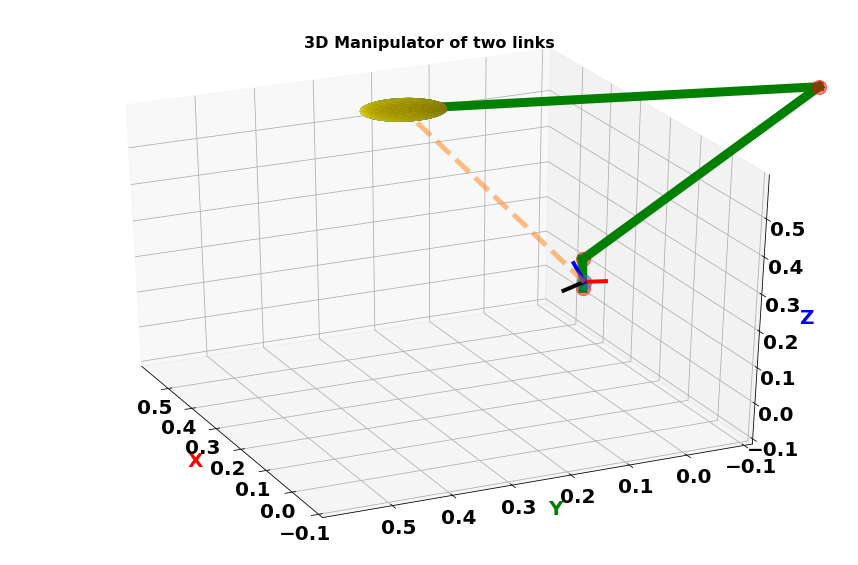

In [107]:
###Plotting the prior ee estimation and predicted posterior distribution
from IPython import display
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
links = foward_kinematics_plot([mu_theta])
robot3D(links,ax)
plot_ellipsoid(mu_xee,covmat_xee,ax)

plt.plot([turretCameraTrans4m[0,3]],[turretCameraTrans4m[1,3]],[turretCameraTrans4m[2,3]],'o',markersize=15,alpha=0.5)
plt.plot([turretCameraTrans4m[0,3],turretCameraTrans4m[0,3] + 0.05*turretCameraTrans4m[0,0]],[turretCameraTrans4m[1,3],turretCameraTrans4m[1,3]+0.05*turretCameraTrans4m[0,1]],[turretCameraTrans4m[2,3],turretCameraTrans4m[2,3]+0.05*turretCameraTrans4m[0,2]],'r-',linewidth=4)
plt.plot([turretCameraTrans4m[0,3],turretCameraTrans4m[0,3] + 0.05*turretCameraTrans4m[1,0]],[turretCameraTrans4m[1,3],turretCameraTrans4m[1,3]+0.05*turretCameraTrans4m[1,1]],[turretCameraTrans4m[2,3],turretCameraTrans4m[2,3]+0.05*turretCameraTrans4m[1,2]],'k-',linewidth=4)
plt.plot([turretCameraTrans4m[0,3],turretCameraTrans4m[0,3] + 0.05*turretCameraTrans4m[2,0]],[turretCameraTrans4m[1,3],turretCameraTrans4m[1,3]+0.05*turretCameraTrans4m[2,1]],[turretCameraTrans4m[2,3],turretCameraTrans4m[2,3]+0.05*turretCameraTrans4m[2,2]],'b-',linewidth=4)

plt.plot([turretCameraTrans4m[0,3], mu_xee[0]],[turretCameraTrans4m[1,3], mu_xee[1]],[turretCameraTrans4m[2,3], mu_xee[2]],'--',linewidth=5,alpha=0.5)

ax.set_xlim(-0.1, 0.6)
ax.set_ylim(-0.1, 0.6)
ax.set_zlim(-0.1, 0.6)

for angle in range(0, 360):
    ax.view_init(30, angle)
    display.clear_output(wait=True)
    display.display(plt.gcf())
# fig = plt.show()

-z----------------> x
|
|    o  o
|     __
|
|
y

In [103]:
#Generate the new sigma points from the ee distribution
sigma_xee = sigma_points(mu_xee,covmat_xee, n_dim,lamda)
#Assign weights to the sigma points
wsm, wsc = weight_sigma(alpha,n_dim,kappa,beta,lamda) 

image_eeHomog = np.ones((sigma_xee.shape[0],3))
#Propagating sigma points through camera model
for i in range(sigma_xee.shape[0]):
    #a = ((sigma_xee[i,:]))#, np.array([1])), axis=0)
    image_eeHomog[i,:] = rtmapping(sigma_xee[i,:], turretCameraTrans4m)

end_effe2D = endEffecImage2d(image_eeHomog)
predictedObservat_mu,predictedUncer_cov = estimate_distri(end_effe2D,wsm, wsc,n_dim,2)

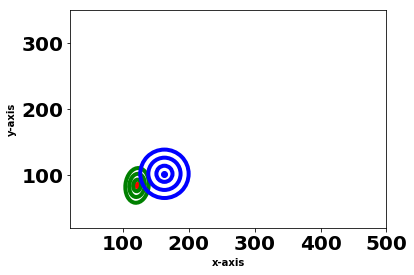

In [104]:
#plot eedistribution obtained by the kinematics vs  the camera distribution 
plot2Dellipse(predictedObservat_mu,predictedUncer_cov,predictedObservat_mu, (20,500), (20,350), "green","red")
plot2Dellipse(sensordata_in2d.reshape(2,1),m_noiseQ,sensordata_in2d.reshape(2,1), (20,500), (20,350),"blue","blue")
plt.show()

In [105]:
#cross covariance between X and Z
cross_cov = np.zeros((3,2))
for i in range(2*(3) + 1):
        cross_cov = cross_cov + wsc[i] *(sigma_xee[i,:].reshape(3,1)
                                     - mu_xee.reshape(3,1)).dot((end_effe2D[i,:].reshape(2,1) 
                                                              - predictedObservat_mu).T)
        
#Compute Kalman gain and the final prediction mean and covariance
kalman_gain = cross_cov.dot(np.linalg.inv(predictedUncer_cov))

# actual_mu_meas is T to align (2,1) dim, mu_xee is reshaped from 3, to 3,1
final_predic_mu = mu_xee.reshape(3,1) + kalman_gain.dot(sensordata_in2d.reshape(2,1) - predictedObservat_mu)
mu_final = np.squeeze(np.asarray(final_predic_mu))
final_predic_cov = covmat_xee - kalman_gain.dot(predictedUncer_cov).dot(kalman_gain.T)

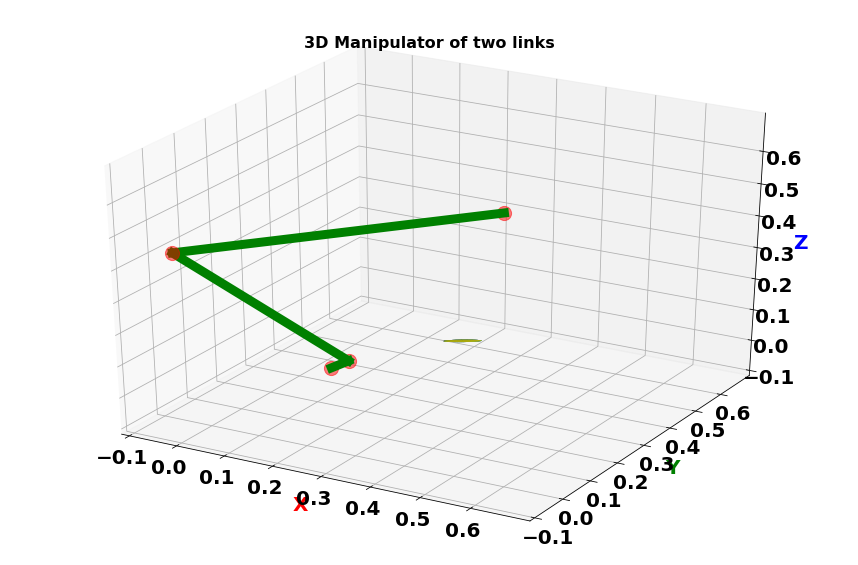

In [106]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
links = foward_kinematics_plot([mu_theta])
robot3D(links,ax)
plot_ellipsoid(mu_final,final_predic_cov,ax)
ax.set_xlim(-0.1, 0.7)
ax.set_ylim(-0.1, 0.7)
ax.set_zlim(-0.1, 0.7)
fig = plt.show()


In [ ]:
'this is the transformation we had for camera ,which only included turret joint'

# def camera_transform(joint_angles):
#     robot = URDF.from_xml_file('robot.urdf')
#     links = [rl.name for rl in robot.links]
#     #print(links)
#     kdl_kin_cam_dy = KDLKinematics(robot,'base_link','turret_link') #maybe up to 'turretCam_link'
#     print(kdl_kin_cam_dy.get_joint_names())
#     cam_list_dy = []
#     for joints in joint_angles:
#         cam_list_dy.append(kdl_kin_cam_dy.forward(joints[:1]))
#     return cam_list_dy
# camHTH = camera_transform(jangles_dynamicbag1)
# print((camHTH[0]).shape)

In [ ]:
# final_camTra = np.dot(zz[0],camHTH[0])
# final_camTra.shape

In [ ]:
#vicon_dylist = []
# for i in range(len(vicobags_dyna)):     
#     vicon_dy = np.load(data_path+'vicon_dynaPosArr%d.npy'%i)
#     vicon_dylist.append(vicon_dy)    
# vicon_endeff_subsetbag1 = vicon_dylist[1]

# #projecting it to the image plane
# ee_poseVicon = rtmapping(vicon_endeff_subsetbag1[0])
# #reuse the func for converting to 2D image plane
# actual_mu_meas = endEffecImage2d(ee_poseVicon)
# actual_point = actual_mu_meas.reshape(2,1)
# nDmeanTo_1d = np.squeeze(np.asarray(actual_point))
